## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 4.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [202]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 0


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [203]:
# Opening JSON file 
f = open('./complaints-2021-05-14_08_16.json',)
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [204]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [205]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [206]:
#lets get the important columns out from the data frame
df = df[['_source.complaint_what_happened', '_source.product', '_source.sub_product']]
df.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [207]:
#Assign new column names
df = df.rename(columns={
        '_source.complaint_what_happened': 'complaint_message', 
        '_source.product': 'category', 
        '_source.sub_product': 'sub_category'
    })
df.head()

,complaint_message,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [208]:
# combining category and sub-catogory
df['category'] = df.category + '+' + df.sub_category
df = df.drop(['sub_category'], axis=1)
df.head()

,complaint_message,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card+General-purpose credit card or charge card
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose credit card or charge card


In [209]:
# checking the null complaint_message
df['complaint_message'].isnull().sum()

0

In [210]:
# checking blank complaint_message strings
len(df[df.complaint_message == ''])

57241

Observation: There are 57241 blank complaint messages

In [211]:
#Assign nan in place of blanks in the complaints column
df[df.complaint_message == ''] = np.nan
df.complaint_message.isnull().sum()

57241

In [212]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_message'].isnull()]
df.complaint_message.isnull().sum()

0

In [213]:
df.head()

,complaint_message,category
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card+General-purpose credit card or charge card
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.","Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report"
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.","Credit reporting, credit repair services, or other personal consumer reports+Credit reporting"
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,Checking or savings account+Checking account


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [214]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower() # make text lowercase
    text = re.sub('\[.*\]', '', text).strip() # removes square backets from the text
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove the puntuations
    text = re.sub('\S*\d\S*\s*', '', text).strip() # remove words containing numbers
    return text.strip()

In [215]:
df.complaint_message = df.complaint_message.apply(lambda x: clean_text(x))

In [216]:
df.head()

,complaint_message,category
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Credit card or prepaid card+General-purpose credit card or charge card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,"Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report"
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,"Credit reporting, credit repair services, or other personal consumer reports+Credit reporting"
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,Checking or savings account+Checking account


In [217]:
#Write your function to Lemmatize the texts
stopwards = nlp.Defaults.stop_words
def lemmatized(text):
    doc = nlp(text)
    sentence = [token.lemma_ for token in doc if not token.text in set(stopwards)]
    return " ".join(sentence)


In [218]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemmatized_complaints'] = df.complaint_message.apply(lambda x: lemmatized(x))
df.head()

,complaint_message,category,lemmatized_complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Debt collection+Credit card debt,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Credit card or prepaid card+General-purpose credit card or charge card,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,"Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,"Credit reporting, credit repair services, or other personal consumer reports+Credit reporting",try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer get apply account statement purchase ticket explicitly tell glad get deny absolutely long interested account ask application withdraw representative oblige happen later put application notwithstanding explicit request 

In [219]:
df_clean = df[['complaint_message', 'lemmatized_complaints']]
df_clean.head()

,complaint_message,lemmatized_complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer get apply account statement purchase ticket explicitly tell glad get deny absolutely long interested account ask application withdraw representative oblige happen later put application notwithstanding explicit request proceed application contrary tell chase representative chase fact ahead open credit account report credit report chase refuse correct information credit report go ahead process application consent error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my accoun

In [220]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
  doc = nlp(text)
  sentence = [token.text for token in doc if token.tag_ == 'NN']
  return ' '.join(sentence)

In [221]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.lemmatized_complaints.apply(lambda x: pos_tag(x))

#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_message,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer get apply account statement purchase ticket explicitly tell glad get deny absolutely long interested account ask application withdraw representative oblige happen late

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([9.236e+03, 6.356e+03, 2.725e+03, 1.276e+03, 7.570e+02, 2.750e+02,
        1.500e+02, 7.100e+01, 6.300e+01, 3.900e+01, 3.700e+01, 1.300e+01,
        1.100e+01, 1.100e+01, 8.000e+00, 8.000e+00, 7.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0. ,   248.5,   497. ,   745.5,   994. ,  1242.5,  1491. ,
         1739.5,  1988. ,  2236.5,  2485. ,  2733.5,  2982. ,  3230.5,
         3479. ,  3727.5,  3976. ,  4224.5,  4473. ,  4721.5,  4970. ,
         5218.5,  5467. ,  5715.5,  5964. ,  6212.5,  6461. ,  6709.5,
         6958. ,  7206.5,  7455. ,  7703.5,  7952. ,  8200.5,  8449. ,
         8697.5,  894

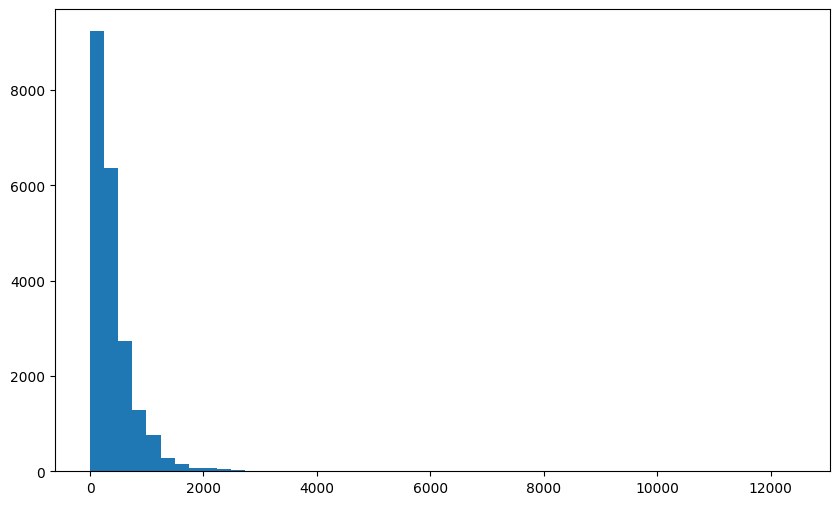

In [222]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10, 6))
document_lengths = [len(doc) for doc in df_clean.complaint_POS_removed]
plt.hist(document_lengths, bins=50)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [223]:
!pip install wordcloud


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


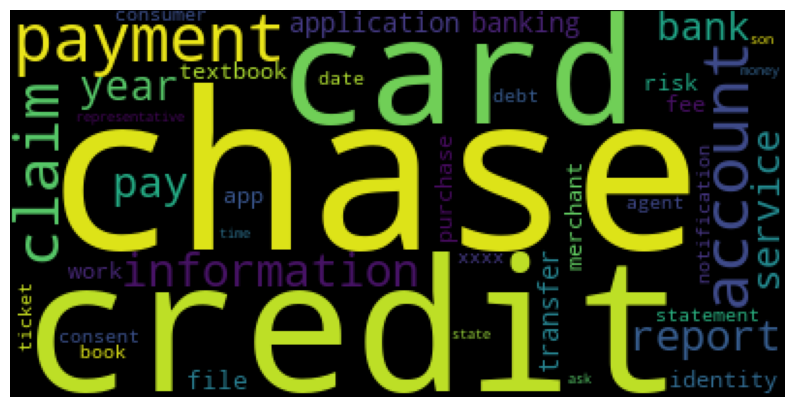

In [224]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

wordCloud = WordCloud(stopwords=stopwards, max_words=40)
wordCloud.generate(str(df_clean.complaint_POS_removed))

print(wordCloud)
plt.figure(figsize=(10, 6))
plt.imshow(wordCloud)
plt.axis('off')
plt.show()

In [225]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
# df_clean = df_clean.drop(['complaint_POS_removed'], axis=1)

In [226]:
df_clean.head()

,complaint_message,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent,card agent upgrade anniversary date change agent information order account anniversary date agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [227]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_n_grams(text, ngram=1, top=None):
    vectorizer = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english')
    bag_of_words = vectorizer.fit_transform(text)

    sum_of_words = bag_of_words.sum(axis=0)
    words_frequency = [(word, sum_of_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

    words_frequency = sorted(words_frequency, key=lambda x: x[1], reverse=True)
    return words_frequency[:top]


In [228]:
top_30_unigrams = get_top_n_grams(df_clean.Complaint_clean, ngram=1, top=30)

In [229]:
#Print the top 10 words in the unigram frequency
top_10_unigram = top_30_unigrams[:10]
print('top 10 unigrams\n')
top_10_unigram

top 10 unigrams



[('chase', 53419),
 ('account', 40961),
 ('credit', 33554),
 ('xxxx', 31291),
 ('card', 29835),
 ('payment', 21064),
 ('bank', 17038),
 ('time', 15871),
 ('charge', 15292),
 ('day', 12831)]

In [230]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = get_top_n_grams(df_clean.Complaint_clean, ngram=2, top=30)


In [231]:
#Print the top 10 words in the bigram frequency
top_10_bigrams = top_30_bigrams[:10]
print('top 10 bigrams\n')
top_10_bigrams

top 10 bigrams



[('credit card', 12773),
 ('credit report', 3893),
 ('chase credit', 3070),
 ('customer service', 2923),
 ('account chase', 2432),
 ('chase bank', 2120),
 ('check account', 2113),
 ('chase account', 2034),
 ('xxxx xxxx', 1954),
 ('contact chase', 1893)]

In [232]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = get_top_n_grams(df_clean.Complaint_clean, ngram=3, top=30)

In [233]:
#Print the top 10 words in the trigram frequency
top_10_trigrams = top_30_trigrams[:10]
print('top 10 trigrams\n')
top_10_trigrams

top 10 trigrams



[('chase credit card', 2196),
 ('credit card account', 1050),
 ('credit card company', 978),
 ('credit card chase', 738),
 ('xxxx credit card', 653),
 ('chase customer service', 559),
 ('inquiry credit report', 483),
 ('credit card credit', 437),
 ('charge credit card', 406),
 ('credit card xxxx', 386)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [234]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [235]:
#All masked texts has been removed
df_clean.head()

,complaint_message,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent,card agent upgrade anniversary date change agent information order account anniversary date agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately cont

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [236]:
#Write your code here to initialise the TfidfVectorizer 

tf_idf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [237]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tf_idf.fit_transform(df_clean.Complaint_clean)

In [238]:
tf_idf.get_feature_names_out()[:5]

array(['aarp', 'abandonment', 'abatement', 'abbreviation', 'abd'],
      dtype=object)

In [239]:
len(tf_idf.get_feature_names_out())

6484

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [240]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [241]:
#Load your nmf_model with the n_components i.e 5
num_topics =  5 

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_


In [242]:
# nmf_model.fit(dtm)
len(tf_idf.get_feature_names_out())

6484

In [243]:
#Print the Top15 words for each of the topics

words = np.array(tf_idf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,deposit,chase,fund,day,branch,transfer,number,business,transaction,customer,claim
Topic 2,card,credit,chase,balance,account,score,limit,year,purchase,point,month,application,service,reason,time
Topic 3,payment,loan,mortgage,chase,month,modification,time,home,pay,year,rate,balance,property,statement,date
Topic 4,report,inquiry,credit,information,company,reporting,debt,account,file,identity,remove,dispute,theft,score,letter
Topic 5,charge,dispute,fee,chase,transaction,merchant,claim,purchase,refund,fraud,service,email,time,contact,statement


In [244]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([0, 1, 3, ..., 3, 1, 2])

In [287]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [288]:
df_clean.head()

,complaint_message,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent,card agent upgrade anniversary date change agent information order account anniversary date agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision imme

In [289]:
#Print the first 5 Complaint for each of the Topics
first_5_complaints=df_clean.groupby('Topic').head(5)
first_5_complaints.sort_values('Topic')

,complaint_message,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
24,mishandling of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,notice jp morgan chase restrict account debit card tuesday thursday go branch advise customer service representative account actually close go branch remove fund currently direct deposit place employment return bank associate customer service representative assure fund post additional business day saturday attempt inside branch retrieve fund actually post friday look account realize fund reverse long present current statement ve call tell business day state t

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [290]:
#Create the dictionary of Topic names and Topics
topic_mapping = {
    0: 'Bank Account services',
    1: 'Others',
    2: 'Mortgage/Loan',
    3: 'Credit card or prepaid card',
    4: 'Theft/Dispute Reporting',
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [291]:
df_clean.head()

,complaint_message,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,Bank Account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent,card agent upgrade anniversary date change agent information order account anniversary date agent,Others
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card i

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [292]:
#Create the dictionary again of Topic names and Topics
Topic_names = { 
    'Bank Account services': 0,
    'Others': 1,
    'Mortgage/Loan': 2,
    'Credit card or prepaid card': 3,
    'Theft/Dispute Reporting': 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [293]:
df_clean.head()

,complaint_message,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,card agent upgrade anniversary date change agent information order account anniversary date agent,card agent upgrade anniversary date change agent information order account anniversary date agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,chase card report application submit identity consent service extend credit verify identity applicant,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision imme

In [294]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['lemmatized_complaints', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [295]:
training_data.head()

,complaint_message,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,3
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [296]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code to get the Vector count
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(training_data.complaint_message)

#Write your code here to transform the word vector to tf-idf
tf_idf_transformer = TfidfTransformer()
X_train_tfidf = tf_idf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [297]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [298]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

In [299]:
# utlity function to display the model report
# credits: Kaggle

def display_classification_report(model,metric):
    
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
  
    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    
    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))
    
    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)
        
    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)
    
    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

### 1. Logistic Regression Classification

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 0.95
Test Accuracy : 0.91
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      4155
           1       0.96      0.94      0.95      3140
           2       0.95      0.98      0.96      4120
           3       0.96      0.88      0.92      1896
           4       0.95      0.93      0.94      3546

    accuracy                           0.95     16857
   macro avg       0.95      0.94      0.94     16857
weighted avg       0.95      0.95      0.95     16857

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      1045
           1       0.92      0.89      0.91       847
           2       0.92      0.95      0.93       990
           3       0.92      0.86      0.89       475
           4       0.90      0.88      0.89       858

    accuracy             

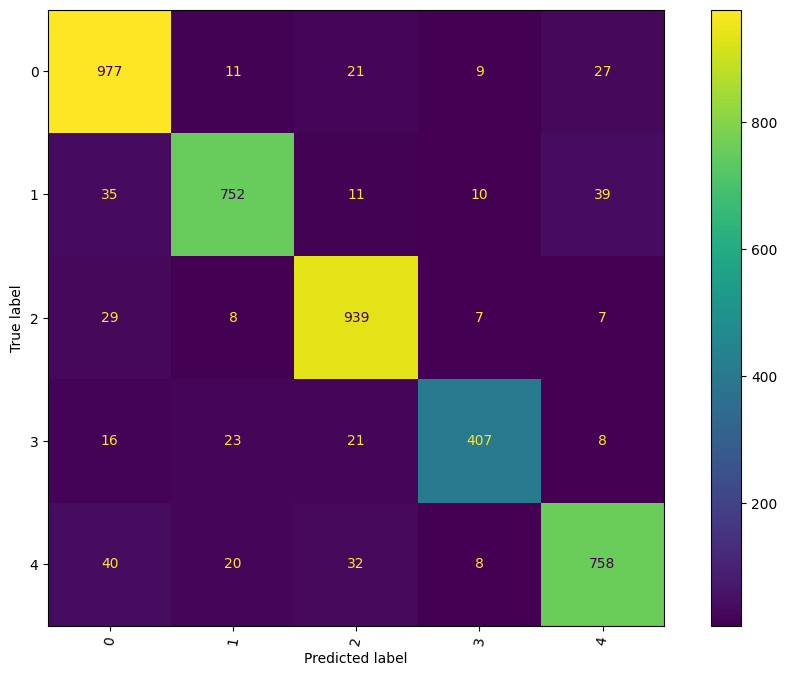

In [300]:


# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(log_reg,metric2)


### 2. Multinomial Naive Bayes Classification

ROC AUC Score Train: 0.96
ROC AUC Score Test: 0.94
Train Accuracy : 0.73
Test Accuracy : 0.68
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.65      0.95      0.77      4155
           1       0.86      0.47      0.61      3140
           2       0.70      0.92      0.79      4120
           3       0.96      0.28      0.43      1896
           4       0.82      0.72      0.76      3546

    accuracy                           0.73     16857
   macro avg       0.80      0.67      0.67     16857
weighted avg       0.77      0.73      0.71     16857

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.61      0.93      0.74      1045
           1       0.79      0.39      0.52       847
           2       0.66      0.91      0.77       990
           3       0.96      0.24      0.38       475
           4       0.77      0.65      0.70       858

    accuracy            

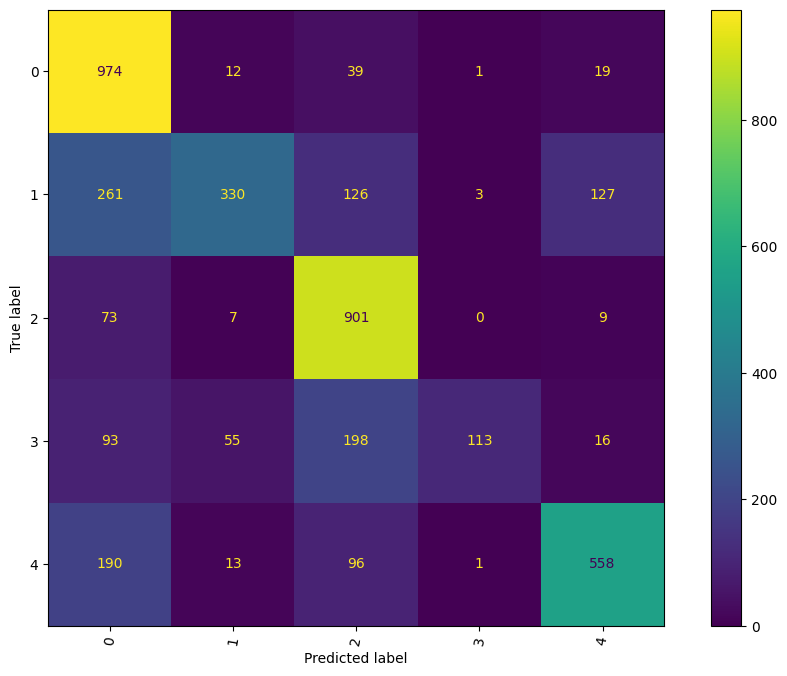

In [301]:
# create MNB model object
mnb = MultinomialNB()
# fit model
mnb.fit(X_train, y_train)
# display classification report
metric1=[]
display_classification_report(mnb,metric1)

### 3. Decision Tree Classification

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.85
Train Accuracy : 1.0
Test Accuracy : 0.76
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4155
           1       1.00      1.00      1.00      3140
           2       1.00      1.00      1.00      4120
           3       1.00      1.00      1.00      1896
           4       1.00      1.00      1.00      3546

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78      1045
           1       0.79      0.78      0.78       847
           2       0.82      0.81      0.82       990
           3       0.72      0.69      0.70       475
           4       0.69      0.68      0.69       858

    accuracy              

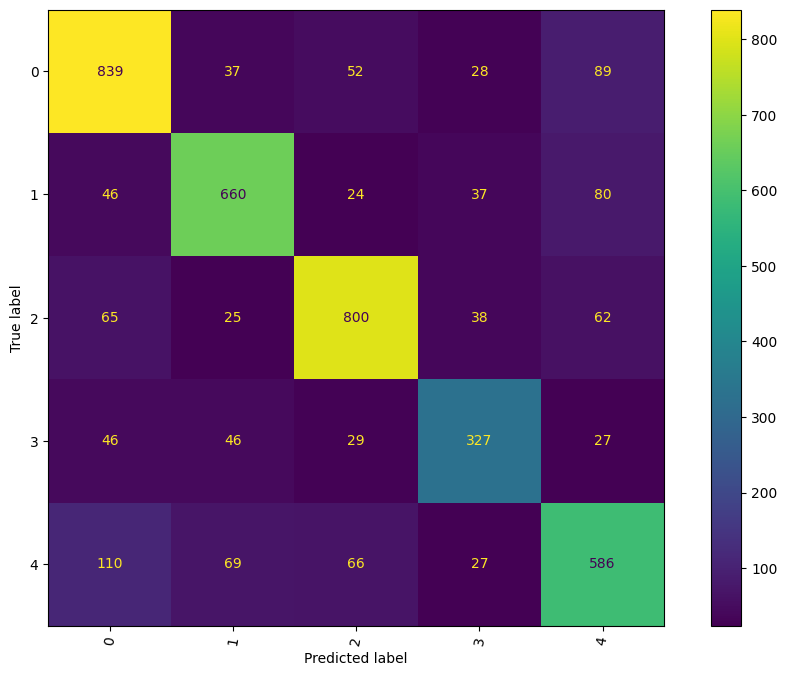

In [302]:
dtc = DecisionTreeClassifier(random_state=40)
# fit model
dtc.fit(X_train,y_train)
# Decision Tree Classification Report
metric3=[]
display_classification_report(dtc,metric3)

### 4. Random Forest Classification

OOB SCORE : 0.8302782226968025
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.98
Train Accuracy : 1.0
Test Accuracy : 0.83
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4155
           1       1.00      1.00      1.00      3140
           2       1.00      1.00      1.00      4120
           3       1.00      1.00      1.00      1896
           4       1.00      1.00      1.00      3546

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85      1045
           1       0.84      0.74      0.79       847
           2       0.85      0.90      0.88       990
           3       0.91      0.72      0.80       475
           4       0.82      0.77      0.79       

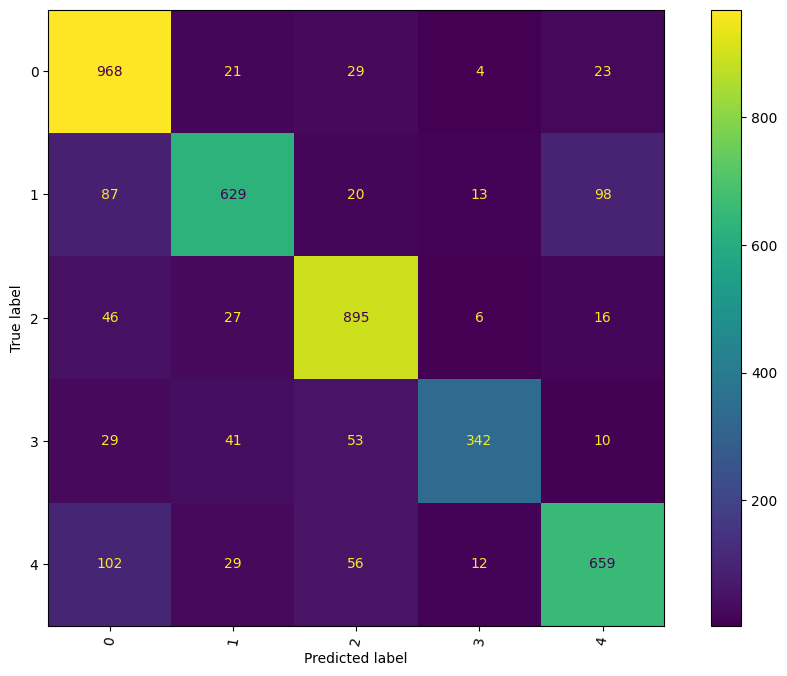

In [303]:
# Random Forest Classification

rf = RandomForestClassifier(n_estimators = 500, random_state = 40, n_jobs = -1, oob_score=True)
# fit model
rf.fit(X_train,y_train)

# oob score
print('OOB SCORE :',rf.oob_score_)

# Random Forest Classification Report
metric4=[]
display_classification_report(rf,metric4)

## Model Inference

Observation: Logistic Regression model is performing well compare to other models so we will do some testing with custom messages.

In [304]:
df_complaints = pd.DataFrame({'complaints': ["I am having issue performing the transaction from my chase credit card",
                                  "Yesterday, I was trying to do the repayment of the due amount for this month towards my mortgage, but was unable to do so and now it is showing overdue by 1 day.",
                                  "Need help opening the salary account, not sure what benefits are offered or is there any thing better?",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "While looking into my CIBIL score I found that there are some wrong entries, and I need help to remove them.",
                                ]})
df_complaints

,complaints
0,I am having issue performing the transaction from my chase credit card
1,"Yesterday, I was trying to do the repayment of the due amount for this month towards my mortgage, but was unable to do so and now it is showing overdue by 1 day."
2,"Need help opening the salary account, not sure what benefits are offered or is there any thing better?"
3,"Yesterday, I received a fraudulent email regarding renewal of my services."
4,"While looking into my CIBIL score I found that there are some wrong entries, and I need help to remove them."


In [305]:
def predict_using_logistic_regression_model(text):
    topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    x_test_count_vect = count_vectorizer.transform(text)
    x_new_tfidf = tf_idf_transformer.transform(x_test_count_vect)
    predicted = log_reg.predict(x_new_tfidf)
    return topic_names[predicted[0]]


In [306]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_using_logistic_regression_model([x]))
df_complaints

,complaints,tag
0,I am having issue performing the transaction from my chase credit card,Others
1,"Yesterday, I was trying to do the repayment of the due amount for this month towards my mortgage, but was unable to do so and now it is showing overdue by 1 day.",Mortgage/Loan
2,"Need help opening the salary account, not sure what benefits are offered or is there any thing better?",Account Services
3,"Yesterday, I received a fraudulent email regarding renewal of my services.",Theft/Dispute Reporting
4,"While looking into my CIBIL score I found that there are some wrong entries, and I need help to remove them.",Credit card or prepaid card
